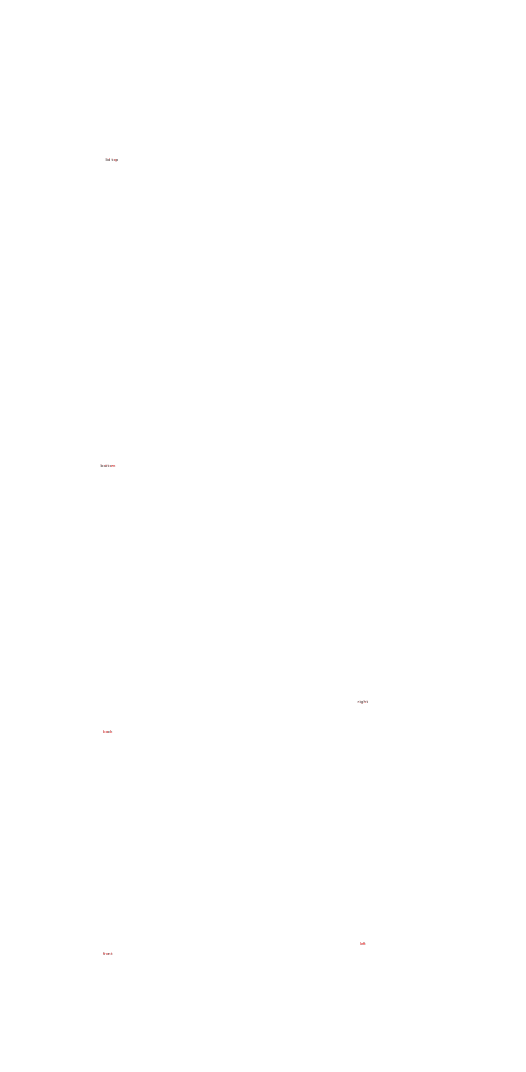

In [47]:
from IPython.display import SVG, display
import sys
import io

sys.path.append('..')  # uncomments and adjust if your Boxes.py copy in not in the Python path
from boxes import *
from boxes import lids
from boxes.edges import Bolts
from boxes.lids import _TopEdge


class PrismaticBattV2(_TopEdge):
    """Box with various options for different styles and lids"""

    ui_group = "Box"

    def __init__(self) -> None:
        Boxes.__init__(self)
        self.addTopEdgeSettings(roundedtriangle={"outset": 1},
                                hinge={"outset": True})
        self.addSettingsArgs(edges.FlexSettings)
        self.addSettingsArgs(lids.LidSettings)
        self.buildArgParser("top_edge", "bottom_edge",
                            "x", "y", "h", "outside")
        self.argparser.add_argument(
            "--vertical_edges", action="store", type=str,
            default="finger joints",
            choices=("finger joints", "finger holes"),
            help="connections used for the vertical edges")

    def rect_holes(self, right=False):
        w, h_full = 2, 0.75 * Z_batt
        yc = Z / 2 + 30
        display_start = self.y / 2 - display_w / 2
        for i in range(20):
            x = 30 + (w + 10) * i
            y = yc
            h = h_full
            if not right:
                if x > display_start - 10 and x < display_start + display_w:
                    h = h_full - display_h - display_battery_offset
                    y = yc - (display_h - display_battery_offset) / 2
                x = self.y - x
            self.rectangularHole(x, y, w, h, center_y=True)
        self.rectangularHole(0, 0, self.y, Z_batt, center_x=False, center_y=False, color=Color.ANNOTATIONS)

    def top_hole(self, x, y, top_edge):
        t = self.thickness

        if top_edge == "f":
            edge = self.edges["F"]
            self.moveTo(2 * t + self.burn, 2 * t, 90)
        elif top_edge == "F":
            edge = self.edges["f"]
            self.moveTo(t + self.burn, 2 * t, 90)
        else:
            raise ValueError("Only f and F supported")

        for l in (y, x, y, x):
            edge(l)
            if top_edge == "F": self.edge(t)
            self.corner(-90)
            if top_edge == "F": self.edge(t)

    def terminal_mounting_holes(self):
        def draw_terminal(x0):
            self.hole(y_center, x0, d=terminal_central_diam)
            self.hole(y_center + ternimal_m4_center_dist / 2, x0 + ternimal_m4_center_dist / 2, d=M4_d)
            self.hole(y_center + ternimal_m4_center_dist / 2, x0 - ternimal_m4_center_dist / 2, d=M4_d)
            self.hole(y_center - ternimal_m4_center_dist / 2, x0 + ternimal_m4_center_dist / 2, d=M4_d)
            self.hole(y_center - ternimal_m4_center_dist / 2, x0 - ternimal_m4_center_dist / 2, d=M4_d)
            self.rectangularHole(y_center, x0, 36, 36, center_x=True, center_y=True, color=Color.ANNOTATIONS)

        y_center = self.thickness + Z_batt + terminal_battery_offset_center
        draw_terminal(self.x / 3)
        draw_terminal(2 * self.x / 3)

    def draw_display(self):
        self.rectangularHole(self.thickness + Z_batt + display_battery_offset + display_h / 2,
                             self.x / 2 + display_w / 2,
                             display_h, display_w, center_y=True, center_x=True)

    def draw_handle(self):
        handle_x = 80
        handle_y = 15
        handle_r = 7
        self.rectangularHole(self.x / 2, Z_batt / 2, handle_x, handle_y, handle_r, center_y=True, center_x=True)
        self.rectangularHole(0, 0, X_batt, Z_batt, center_x=False, center_y=False, color=Color.ANNOTATIONS)

    def render(self):
        x, y, h = self.x, self.y, self.h
        t = self.thickness

        tl, tb, tr, tf = self.topEdges(self.top_edge)
        b = self.edges.get(self.bottom_edge, self.edges["F"])

        d2 = Bolts(2)
        d3 = Bolts(3)

        d2 = d3 = None

        sideedge = "F" if self.vertical_edges == "finger joints" else "h"

        if self.outside:
            self.x = x = self.adjustSize(x, sideedge, sideedge)
            self.y = y = self.adjustSize(y)
            self.h = h = self.adjustSize(h, b, self.top_edge)

        with self.saved_context():
            self.rectangularWall(x, h, [b, sideedge, tf, sideedge],
                                 ignore_widths=[1, 6],
                                 bedBolts=[d2], move="up", label="front",
                                 callback=[self.draw_handle, self.terminal_mounting_holes])
            self.rectangularWall(x, h, [b, sideedge, tb, sideedge],
                                 ignore_widths=[1, 6],
                                 bedBolts=[d2], move="up", label="back", callback=[self.draw_handle])

            if self.bottom_edge != "e":
                self.rectangularWall(x, y, "ffff", bedBolts=[d2, d3, d2, d3], move="up", label="bottom", callback=[])
            if self.top_edge in "fF":
                self.set_source_color(
                    Color.MAGENTA)  # I don't know why this part has a different color, but RED is not a good choice because RED is used for annotations
                self.rectangularWall(x + 4 * t, y + 4 * t, callback=[
                    lambda: self.top_hole(x, y, self.top_edge)], move="up", label="top hole")
                self.set_source_color(Color.BLACK)
            self.drawLid(x, y, self.top_edge, [d2, d3])
            self.lid(x, y, self.top_edge)

        self.rectangularWall(x, h, [b, sideedge, tf, sideedge],
                             ignore_widths=[1, 6],
                             bedBolts=[d2], move="right only", label="invisible")
        self.rectangularWall(y, h, [b, "f", tl, "f"],
                             ignore_widths=[1, 6],
                             bedBolts=[d3], move="up", label="left",
                             callback=[lambda: self.rect_holes(False), self.draw_display])
        self.rectangularWall(y, h, [b, "f", tr, "f"],
                             ignore_widths=[1, 6],
                             bedBolts=[d3], move="up", label="right", callback=[lambda: self.rect_holes(True)])


thickness = 8.0
# Add thickness to account for the opening wall space
Y = 270 + thickness * 2.5
X = 180
Z = 210

X_batt = 150
Z_batt = 140  # with terminals

ternimal_m4_center_dist = 23
terminal_central_diam = 22
terminal_battery_offset_center = 40
M4_d = 4.2

display_w = 95
display_h = 56
display_battery_offset = 0

file_format = "svg"

b = PrismaticBattV2()
b.parseArgs(['--reference=0', '--burn=0', '--debug=0', f'--thickness={thickness}', '--top_edge=i', '--bottom_edge=F',
             f'--x={X}', f'--y={Y}', f'--h={Z}', '--outside=0', '--Hinge_style=flush'])
# b.parseArgs()
b.open()
b.render()
data = b.close()

with open(f'{b.__class__.__name__}.{file_format}', "wb") as f:
    if isinstance(data, io.BufferedReader):
        # dxf
        f.write(data.read())
    else:
        # svg
        f.write(data.getbuffer())

if file_format == "svg":
    display(SVG(data=data.getvalue()))